In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


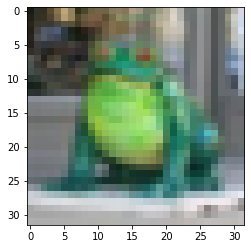

In [2]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

In [3]:
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Write my own function, for color jitter?

In [4]:
 transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        # ColourDistortion(s=0.5),
        transforms.ToTensor(),
        # transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])

# now there are only random 1) crop 2) flip
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

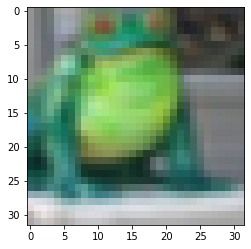

In [66]:
pic = train[19][0]
imshow(transform_train(pic))

# Use code from Torch vision source code and make sure it runs

In [5]:
import torch
import numbers
import random
from torch import Tensor

In [68]:
def _is_tensor_a_torch_image(x: Tensor) -> bool:
    return x.ndim >= 2
def _blend(img1: Tensor, img2: Tensor, ratio: float) -> Tensor:
    bound = 1 if img1.dtype in [torch.half, torch.float32, torch.float64] else 255
    return (ratio * img1 + (1 - ratio) * img2).clamp(0, bound).to(img1.dtype)

In [69]:
test_pic = transform_train(pic)

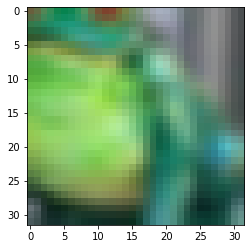

In [70]:
imshow(test_pic)

In [71]:
test_pic.size()

torch.Size([3, 32, 32])

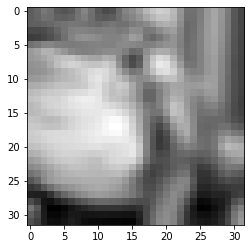

In [72]:
# code from functional_tensor
def rgb_to_grayscale(img: Tensor) -> Tensor:
    """Convert the given RGB Image Tensor to Grayscale.
    For RGB to Grayscale conversion, ITU-R 601-2 luma transform is performed which
    is L = R * 0.2989 + G * 0.5870 + B * 0.1140

    Args:
        img (Tensor): Image to be converted to Grayscale in the form [C, H, W].

    Returns:
        Tensor: Grayscale image.

    """
    if img.shape[0] != 3:
        raise TypeError('Input Image does not contain 3 Channels')

    return (0.2989 * img[0] + 0.5870 * img[1] + 0.1140 * img[2]).to(img.dtype)

plt.imshow(rgb_to_grayscale(test_pic), cmap='gray')

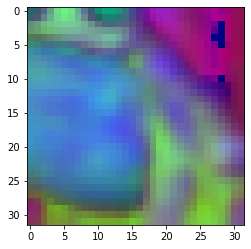

In [73]:
def _rgb2hsv(img):
    r, g, b = img.unbind(0)

    maxc = torch.max(img, dim=0).values
    minc = torch.min(img, dim=0).values

    # The algorithm erases S and H channel where `maxc = minc`. This avoids NaN
    # from happening in the results, because
    #   + S channel has division by `maxc`, which is zero only if `maxc = minc`
    #   + H channel has division by `(maxc - minc)`.
    #
    # Instead of overwriting NaN afterwards, we just prevent it from occuring so
    # we don't need to deal with it in case we save the NaN in a buffer in
    # backprop, if it is ever supported, but it doesn't hurt to do so.
    eqc = maxc == minc

    cr = maxc - minc
    # Since `eqc => cr = 0`, replacing denominator with 1 when `eqc` is fine.
    s = cr / torch.where(eqc, maxc.new_ones(()), maxc)
    # Note that `eqc => maxc = minc = r = g = b`. So the following calculation
    # of `h` would reduce to `bc - gc + 2 + rc - bc + 4 + rc - bc = 6` so it
    # would not matter what values `rc`, `gc`, and `bc` have here, and thus
    # replacing denominator with 1 when `eqc` is fine.
    cr_divisor = torch.where(eqc, maxc.new_ones(()), cr)
    rc = (maxc - r) / cr_divisor
    gc = (maxc - g) / cr_divisor
    bc = (maxc - b) / cr_divisor

#     hr = (maxc == r) * (bc - gc)
#     hg = ((maxc == g) & (maxc != r)) * (2.0 + rc - bc)
#     hb = ((maxc != g) & (maxc != r)) * (4.0 + gc - rc)   
    hr = (maxc == r).float() * (bc - gc)
    hg = ((maxc == g) & (maxc != r)).float() * (2.0 + rc - bc)
    hb = ((maxc != g) & (maxc != r)).float() * (4.0 + gc - rc)
    h = (hr + hg + hb)
    h = torch.fmod((h / 6.0 + 1.0), 1.0)
    return torch.stack((h, s, maxc))

imshow(_rgb2hsv(test_pic))

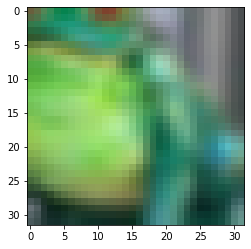

In [74]:
def _hsv2rgb(img):
    h, s, v = img.unbind(0)
    i = torch.floor(h * 6.0)
    f = (h * 6.0) - i
    i = i.to(dtype=torch.int32)

    p = torch.clamp((v * (1.0 - s)), 0.0, 1.0)
    q = torch.clamp((v * (1.0 - s * f)), 0.0, 1.0)
    t = torch.clamp((v * (1.0 - s * (1.0 - f))), 0.0, 1.0)
    i = i % 6

#     mask = i == torch.arange(6)[:, None, None]
    mask = (i == torch.arange(6)[:, None, None].to(img.device).int())
    a1 = torch.stack((v, q, p, p, t, v))
    a2 = torch.stack((t, v, v, q, p, p))
    a3 = torch.stack((p, p, t, v, v, q))
    a4 = torch.stack((a1, a2, a3))

    return torch.einsum("ijk, xijk -> xjk", mask.to(dtype=img.dtype), a4)
imshow(_hsv2rgb(_rgb2hsv(test_pic)))

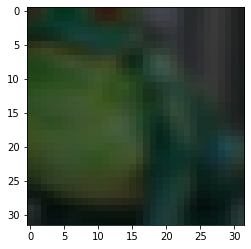

In [75]:
def adjust_brightness(img: Tensor, brightness_factor: float) -> Tensor:
    """Adjust brightness of an RGB image.

    Args:
        img (Tensor): Image to be adjusted.
        brightness_factor (float):  How much to adjust the brightness. Can be
            any non negative number. 0 gives a black image, 1 gives the
            original image while 2 increases the brightness by a factor of 2.

    Returns:
        Tensor: Brightness adjusted image.
    """
    if brightness_factor < 0:
        raise ValueError('brightness_factor ({}) is not non-negative.'.format(brightness_factor))

    if not _is_tensor_a_torch_image(img):
        raise TypeError('tensor is not a torch image.')

    return _blend(img, torch.zeros_like(img), brightness_factor)
imshow(adjust_brightness(test_pic, brightness_factor = 0.4))

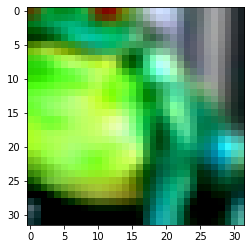

In [76]:
def adjust_contrast(img: Tensor, contrast_factor: float) -> Tensor:
    """Adjust contrast of an RGB image.

    Args:
        img (Tensor): Image to be adjusted.
        contrast_factor (float): How much to adjust the contrast. Can be any
            non negative number. 0 gives a solid gray image, 1 gives the
            original image while 2 increases the contrast by a factor of 2.

    Returns:
        Tensor: Contrast adjusted image.
    """
    if contrast_factor < 0:
        raise ValueError('contrast_factor ({}) is not non-negative.'.format(contrast_factor))

    if not _is_tensor_a_torch_image(img):
        raise TypeError('tensor is not a torch image.')

    mean = torch.mean(rgb_to_grayscale(img))

    return _blend(img, mean, contrast_factor)
imshow(adjust_contrast(test_pic, contrast_factor = 2))

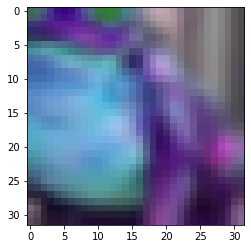

In [77]:
def adjust_hue(img, hue_factor):
    """Adjust hue of an image.

    The image hue is adjusted by converting the image to HSV and
    cyclically shifting the intensities in the hue channel (H).
    The image is then converted back to original image mode.

    `hue_factor` is the amount of shift in H channel and must be in the
    interval `[-0.5, 0.5]`.

    See `Hue`_ for more details.

    .. _Hue: https://en.wikipedia.org/wiki/Hue

    Args:
        img (Tensor): Image to be adjusted. Image type is either uint8 or float.
        hue_factor (float):  How much to shift the hue channel. Should be in
            [-0.5, 0.5]. 0.5 and -0.5 give complete reversal of hue channel in
            HSV space in positive and negative direction respectively.
            0 means no shift. Therefore, both -0.5 and 0.5 will give an image
            with complementary colors while 0 gives the original image.

    Returns:
         Tensor: Hue adjusted image.
    """
    if not (-0.5 <= hue_factor <= 0.5):
        raise ValueError('hue_factor ({}) is not in [-0.5, 0.5].'.format(hue_factor))

    if not _is_tensor_a_torch_image(img):
        raise TypeError('tensor is not a torch image.')

    orig_dtype = img.dtype
    if img.dtype == torch.uint8:
        img = img.to(dtype=torch.float32) / 255.0

    img = _rgb2hsv(img)
    h, s, v = img.unbind(0)
    h += hue_factor
    h = h % 1.0
    img = torch.stack((h, s, v))
    img_hue_adj = _hsv2rgb(img)

    if orig_dtype == torch.uint8:
        img_hue_adj = (img_hue_adj * 255.0).to(dtype=orig_dtype)

    return img_hue_adj

imshow(adjust_hue(test_pic, hue_factor = 0.3))

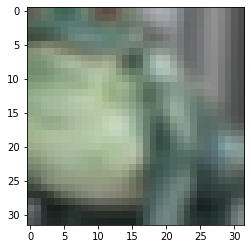

In [78]:
def adjust_saturation(img: Tensor, saturation_factor: float) -> Tensor:
    """Adjust color saturation of an RGB image.

    Args:
        img (Tensor): Image to be adjusted.
        saturation_factor (float):  How much to adjust the saturation. Can be any
            non negative number. 0 gives a black and white image, 1 gives the
            original image while 2 enhances the saturation by a factor of 2.

    Returns:
        Tensor: Saturation adjusted image.
    """
    if saturation_factor < 0:
        raise ValueError('saturation_factor ({}) is not non-negative.'.format(saturation_factor))

    if not _is_tensor_a_torch_image(img):
        raise TypeError('tensor is not a torch image.')

    return _blend(img, rgb_to_grayscale(img), saturation_factor)
imshow(adjust_saturation(test_pic, saturation_factor = 0.3))

# Rewrite ColorJitter function

In [79]:
class ColorJitter(torch.nn.Module):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

#     @torch.jit.unused
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

#     @staticmethod
#     @torch.jit.unused
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

#         if brightness is not None:
#             brightness_factor = random.uniform(brightness[0], brightness[1])
#             transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

#         if contrast is not None:
#             contrast_factor = random.uniform(contrast[0], contrast[1])
#             transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

#         if saturation is not None:
#             saturation_factor = random.uniform(saturation[0], saturation[1])
#             transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

#         if hue is not None:
#             hue_factor = random.uniform(hue[0], hue[1])
#             transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))
            
            
        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: Color jittered image.
        """
#         fn_idx = torch.randperm(4)
#         for fn_id in fn_idx:
#             if fn_id == 0 and self.brightness is not None:
#                 brightness = self.brightness
#                 brightness_factor = torch.tensor(1.0).uniform_(brightness[0], brightness[1]).item()
#                 img = F.adjust_brightness(img, brightness_factor)

#             if fn_id == 1 and self.contrast is not None:
#                 contrast = self.contrast
#                 contrast_factor = torch.tensor(1.0).uniform_(contrast[0], contrast[1]).item()
#                 img = F.adjust_contrast(img, contrast_factor)

#             if fn_id == 2 and self.saturation is not None:
#                 saturation = self.saturation
#                 saturation_factor = torch.tensor(1.0).uniform_(saturation[0], saturation[1]).item()
#                 img = F.adjust_saturation(img, saturation_factor)

#             if fn_id == 3 and self.hue is not None:
#                 hue = self.hue
#                 hue_factor = torch.tensor(1.0).uniform_(hue[0], hue[1]).item()
#                 img = F.adjust_hue(img, hue_factor)
                
        #### index
        brightness_factor = None
        contrast_factor = None
        saturation_factor = None
        hue_factor = None
        
        fn_idx = torch.randperm(4)
        for fn_id in fn_idx:
            if fn_id == 0 and self.brightness is not None:
                brightness = self.brightness
                brightness_factor = torch.tensor(1.0).uniform_(brightness[0], brightness[1]).item()
                img = adjust_brightness(img, brightness_factor)

            if fn_id == 1 and self.contrast is not None:
                contrast = self.contrast
                contrast_factor = torch.tensor(1.0).uniform_(contrast[0], contrast[1]).item()
                img = adjust_contrast(img, contrast_factor)

            if fn_id == 2 and self.saturation is not None:
                saturation = self.saturation
                saturation_factor = torch.tensor(1.0).uniform_(saturation[0], saturation[1]).item()
                img = adjust_saturation(img, saturation_factor)

            if fn_id == 3 and self.hue is not None:
                hue = self.hue
                hue_factor = torch.tensor(1.0).uniform_(hue[0], hue[1]).item()
                img = adjust_hue(img, hue_factor)
                
        #also return the coefficient
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={:.3f}'.format(brightness_factor)
        format_string += ', contrast={:.3f}'.format(contrast_factor)
        format_string += ', saturation={:.3f}'.format(saturation_factor)
        format_string += ', hue={:.3f})'.format(hue_factor)
        print(format_string)

        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string

In [80]:
aug = ColorJitter(brightness=0.3, contrast=0.5, saturation=0.2, hue=[-0.2, 0.4])

In [81]:
aug.__repr__()

'ColorJitter(brightness=[0.7, 1.3], contrast=[0.5, 1.5], saturation=[0.8, 1.2], hue=[-0.2, 0.4])'

ColorJitter(brightness=0.864, contrast=0.887, saturation=0.916, hue=-0.170)


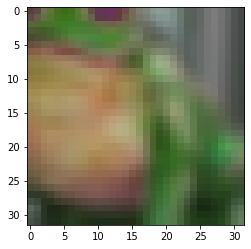

In [82]:
imshow(aug(test_pic))

# Color Augmentation class

In [83]:
class DifferentiableColourDistortionByTorch(nn.Module):
    
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

#     @torch.jit.unused
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value
    
    #### batch color augmentation forward #####
    
    def forward(self, x):
        '''
        Args:
            x: Input tensor batchsize x 32 x 32
        
        Returns:
            x_aug : color jittered image
        
        '''
        xu = torch.unbind(x, dim=0)
        aug_x = torch.stack([self.colordistort(x_i) for i,x_i in enumerate(xu)], dim = 0)

        
        return aug_x
    
    def colordistort(self, img: Tensor)-> Tensor:
        if (torch.rand(1)<0.8):
            img = self.colorjitter(img)
            #print(x_i.shape)
        if (torch.rand(1)<0.2):
            img = self.rgb_to_grayscale(img)
            img = img.repeat(3,1,1) # reshape to r==g==b
            #print(x_i.shape)    
        return img
        
        
    def colorjitter(self, img):
        """
        Args:
            img (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: Color jittered image.
        """     
        #### index
#         brightness_factor = None
#         contrast_factor = None
#         saturation_factor = None
#         hue_factor = None
        
        fn_idx = torch.randperm(4)
        for fn_id in fn_idx:
            if fn_id == 0 and self.brightness is not None:
                brightness = self.brightness
                brightness_factor = torch.tensor(1.0).uniform_(brightness[0], brightness[1]).item()
                img = self.adjust_brightness(img, brightness_factor)

            if fn_id == 1 and self.contrast is not None:
                contrast = self.contrast
                contrast_factor = torch.tensor(1.0).uniform_(contrast[0], contrast[1]).item()
                img = self.adjust_contrast(img, contrast_factor)

            if fn_id == 2 and self.saturation is not None:
                saturation = self.saturation
                saturation_factor = torch.tensor(1.0).uniform_(saturation[0], saturation[1]).item()
                img = self.adjust_saturation(img, saturation_factor)

            if fn_id == 3 and self.hue is not None:
                hue = self.hue
                hue_factor = torch.tensor(1.0).uniform_(hue[0], hue[1]).item()
                img = self.adjust_hue(img, hue_factor)
                
        #also return the coefficient
#         format_string = self.__class__.__name__ + '('
#         format_string += 'brightness={:.3f}'.format(brightness_factor)
#         format_string += ', contrast={:.3f}'.format(contrast_factor)
#         format_string += ', saturation={:.3f}'.format(saturation_factor)
#         format_string += ', hue={:.3f})'.format(hue_factor)
        #print(format_string)

        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string
                
    ##### function from pytorch source code #####
    def _is_tensor_a_torch_image(self, x: Tensor) -> bool:
        return x.ndim >= 2
    
    def _blend(self, img1: Tensor, img2: Tensor, ratio: float) -> Tensor:
        bound = 1 if img1.dtype in [torch.half, torch.float32, torch.float64] else 255
        return (ratio * img1 + (1 - ratio) * img2).clamp(0, bound).to(img1.dtype)
    
    def rgb_to_grayscale(self, img: Tensor) -> Tensor:
        """Convert the given RGB Image Tensor to Grayscale.
        For RGB to Grayscale conversion, ITU-R 601-2 luma transform is performed which
        is L = R * 0.2989 + G * 0.5870 + B * 0.1140

        Args:
            img (Tensor): Image to be converted to Grayscale in the form [C, H, W].

        Returns:
            Tensor: Grayscale image.

        """
        if img.shape[0] != 3:
            raise TypeError('Input Image does not contain 3 Channels')

        return (0.2989 * img[0] + 0.5870 * img[1] + 0.1140 * img[2]).to(img.dtype)
    
    def _rgb2hsv(self, img):
        r, g, b = img.unbind(0)

        maxc = torch.max(img, dim=0).values
        minc = torch.min(img, dim=0).values

        # The algorithm erases S and H channel where `maxc = minc`. This avoids NaN
        # from happening in the results, because
        #   + S channel has division by `maxc`, which is zero only if `maxc = minc`
        #   + H channel has division by `(maxc - minc)`.
        #
        # Instead of overwriting NaN afterwards, we just prevent it from occuring so
        # we don't need to deal with it in case we save the NaN in a buffer in
        # backprop, if it is ever supported, but it doesn't hurt to do so.
        eqc = maxc == minc

        cr = maxc - minc
        # Since `eqc => cr = 0`, replacing denominator with 1 when `eqc` is fine.
        s = cr / torch.where(eqc, maxc.new_ones(()), maxc)
        # Note that `eqc => maxc = minc = r = g = b`. So the following calculation
        # of `h` would reduce to `bc - gc + 2 + rc - bc + 4 + rc - bc = 6` so it
        # would not matter what values `rc`, `gc`, and `bc` have here, and thus
        # replacing denominator with 1 when `eqc` is fine.
        cr_divisor = torch.where(eqc, maxc.new_ones(()), cr)
        rc = (maxc - r) / cr_divisor
        gc = (maxc - g) / cr_divisor
        bc = (maxc - b) / cr_divisor

    #     hr = (maxc == r) * (bc - gc)
    #     hg = ((maxc == g) & (maxc != r)) * (2.0 + rc - bc)
    #     hb = ((maxc != g) & (maxc != r)) * (4.0 + gc - rc)   
        hr = (maxc == r).float() * (bc - gc)
        hg = ((maxc == g) & (maxc != r)).float() * (2.0 + rc - bc)
        hb = ((maxc != g) & (maxc != r)).float() * (4.0 + gc - rc)
        h = (hr + hg + hb)
        h = torch.fmod((h / 6.0 + 1.0), 1.0)
        return torch.stack((h, s, maxc))
    
    def _hsv2rgb(self, img):
        h, s, v = img.unbind(0)
        i = torch.floor(h * 6.0)
        f = (h * 6.0) - i
        i = i.to(dtype=torch.int32)

        p = torch.clamp((v * (1.0 - s)), 0.0, 1.0)
        q = torch.clamp((v * (1.0 - s * f)), 0.0, 1.0)
        t = torch.clamp((v * (1.0 - s * (1.0 - f))), 0.0, 1.0)
        i = i % 6

    #     mask = i == torch.arange(6)[:, None, None]
        mask = (i == torch.arange(6)[:, None, None].to(img.device).int())
        a1 = torch.stack((v, q, p, p, t, v))
        a2 = torch.stack((t, v, v, q, p, p))
        a3 = torch.stack((p, p, t, v, v, q))
        a4 = torch.stack((a1, a2, a3))

        return torch.einsum("ijk, xijk -> xjk", mask.to(dtype=img.dtype), a4)
    
    #### Brightness ####
    def adjust_brightness(self, img: Tensor, brightness_factor: float) -> Tensor:
        """Adjust brightness of an RGB image.

        Args:
            img (Tensor): Image to be adjusted.
            brightness_factor (float):  How much to adjust the brightness. Can be
                any non negative number. 0 gives a black image, 1 gives the
                original image while 2 increases the brightness by a factor of 2.

        Returns:
            Tensor: Brightness adjusted image.
        """
        if brightness_factor < 0:
            raise ValueError('brightness_factor ({}) is not non-negative.'.format(brightness_factor))

        if not self._is_tensor_a_torch_image(img):
            raise TypeError('tensor is not a torch image.')

        return self._blend(img, torch.zeros_like(img), brightness_factor)
    
    #### Contrast ####
    def adjust_contrast(self, img: Tensor, contrast_factor: float) -> Tensor:
        """Adjust contrast of an RGB image.

        Args:
            img (Tensor): Image to be adjusted.
            contrast_factor (float): How much to adjust the contrast. Can be any
                non negative number. 0 gives a solid gray image, 1 gives the
                original image while 2 increases the contrast by a factor of 2.

        Returns:
            Tensor: Contrast adjusted image.
        """
        if contrast_factor < 0:
            raise ValueError('contrast_factor ({}) is not non-negative.'.format(contrast_factor))

        if not self._is_tensor_a_torch_image(img):
            raise TypeError('tensor is not a torch image.')

        mean = torch.mean(self.rgb_to_grayscale(img).to(torch.float))

        return self._blend(img, mean, contrast_factor)
    
    #### Hue ####
    def adjust_hue(self, img, hue_factor):
        """Adjust hue of an image.

        The image hue is adjusted by converting the image to HSV and
        cyclically shifting the intensities in the hue channel (H).
        The image is then converted back to original image mode.

        `hue_factor` is the amount of shift in H channel and must be in the
        interval `[-0.5, 0.5]`.

        See `Hue`_ for more details.

        .. _Hue: https://en.wikipedia.org/wiki/Hue

        Args:
            img (Tensor): Image to be adjusted. Image type is either uint8 or float.
            hue_factor (float):  How much to shift the hue channel. Should be in
                [-0.5, 0.5]. 0.5 and -0.5 give complete reversal of hue channel in
                HSV space in positive and negative direction respectively.
                0 means no shift. Therefore, both -0.5 and 0.5 will give an image
                with complementary colors while 0 gives the original image.

        Returns:
             Tensor: Hue adjusted image.
        """
        if not (-0.5 <= hue_factor <= 0.5):
            raise ValueError('hue_factor ({}) is not in [-0.5, 0.5].'.format(hue_factor))

        if not self._is_tensor_a_torch_image(img):
            raise TypeError('tensor is not a torch image.')

        orig_dtype = img.dtype
        if img.dtype == torch.uint8:
            img = img.to(dtype=torch.float32) / 255.0

        img = self._rgb2hsv(img)
        h, s, v = img.unbind(0)
        h += hue_factor
        h = h % 1.0
        img = torch.stack((h, s, v))
        img_hue_adj = self._hsv2rgb(img)

        if orig_dtype == torch.uint8:
            img_hue_adj = (img_hue_adj * 255.0).to(dtype=orig_dtype)

        return img_hue_adj
    
    def adjust_saturation(self, img: Tensor, saturation_factor: float) -> Tensor:
        """Adjust color saturation of an RGB image.

        Args:
            img (Tensor): Image to be adjusted.
            saturation_factor (float):  How much to adjust the saturation. Can be any
                non negative number. 0 gives a black and white image, 1 gives the
                original image while 2 enhances the saturation by a factor of 2.

        Returns:
            Tensor: Saturation adjusted image.
        """
        if saturation_factor < 0:
            raise ValueError('saturation_factor ({}) is not non-negative.'.format(saturation_factor))

        if not self._is_tensor_a_torch_image(img):
            raise TypeError('tensor is not a torch image.')

        return self._blend(img, self.rgb_to_grayscale(img), saturation_factor)



    

In [84]:
aug = DifferentiableColourDistortionByTorch(brightness=0.3, contrast=0.5, saturation=0.2, hue=[-0.2, 0.4])

In [85]:
aug.__repr__()

'DifferentiableColourDistortionByTorch(brightness=[0.7, 1.3], contrast=[0.5, 1.5], saturation=[0.8, 1.2], hue=[-0.2, 0.4])'

# Batch color augmentation test

In [6]:
t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')

Loss: ****           | 0/98 [00:00<?, ?it/s]

In [7]:
for batch_idx, (inputs, _, _) in t:
        x1, x2 = inputs
        x1, x2 = x1.to('cuda'), x2.to('cuda')

Loss: **** ██████████| 98/98 [00:11<00:00,  8.48it/s]


In [88]:
x1.size()

torch.Size([336, 3, 32, 32])

In [89]:
x1[0].size()

torch.Size([3, 32, 32])

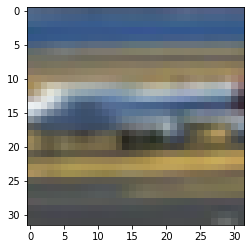

In [90]:
imshow(x1[0].to('cpu'))

In [91]:
aug = DifferentiableColourDistortionByTorch(brightness=0.6, contrast=[0.5, 1.2], saturation=0.2, hue=0.3)

In [92]:
aug(x1).size()

torch.Size([336, 3, 32, 32])

# Optimise code

In [93]:
xu = torch.unbind(x1, dim=0)

In [94]:
torch.stack([adjust_saturation(x, saturation_factor = 0.3) for i,x in enumerate(xu)], dim = 0).size()

torch.Size([336, 3, 32, 32])

In [95]:
# Batch_blend
x1.size()

torch.Size([336, 3, 32, 32])

In [96]:
torch.zeros_like(x1).size()

torch.Size([336, 3, 32, 32])

In [97]:
B = x1.size()[0]

In [98]:
brightness = [0.5,0.8]
brightness_factor  = torch.torch.rand(B)*(brightness[1] - brightness[0]) + brightness[0]

In [99]:
brightness_reshape = brightness_factor.reshape(B,1,1,1).to(x1.device)
brightness_c_reshape = (1- brightness_factor).reshape(B,1,1,1).to(x1.device)

In [100]:
brightness_reshape.size()

torch.Size([336, 1, 1, 1])

In [101]:
x1[1][0]

tensor([[0.0118, 0.0510, 0.1490,  ..., 0.5843, 0.6549, 0.5569],
        [0.1216, 0.0706, 0.0745,  ..., 0.6078, 0.6627, 0.5333],
        [0.2667, 0.1765, 0.1059,  ..., 0.5961, 0.6392, 0.4510],
        ...,
        [0.0510, 0.0588, 0.0706,  ..., 0.4235, 0.4627, 0.4353],
        [0.1020, 0.1137, 0.1373,  ..., 0.4431, 0.4353, 0.3843],
        [0.1765, 0.1922, 0.2275,  ..., 0.3882, 0.3529, 0.3490]],
       device='cuda:0')

In [102]:
brightness_reshape[1]

tensor([[[0.5218]]], device='cuda:0')

# Batch adjust brightness

In [103]:
# batch adjust brightness
def batch_adjust_brightness(img: Tensor, brightness_bound: list) -> Tensor:
    '''
    Batch x C x H x  W -> Batch x C x H x W
    '''
    batch_size = img.size()[0]
    brightness_list = torch.torch.rand(B)*(brightness_bound[1] - brightness_bound[0]) + brightness_bound[0]
    brightness_factor = brightness_list.reshape(B,1,1,1).to(img.device)
    return _blend(img, torch.zeros_like(img), brightness_factor)

In [104]:
adjbn_x = batch_adjust_brightness(x1, brightness_bound = [0.3,2.0])

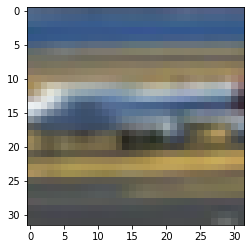

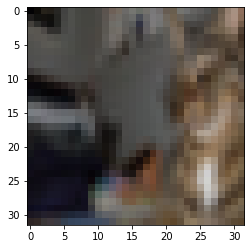

In [105]:
imshow(x1[0].to('cpu'))
imshow(x1[1].to('cpu'))

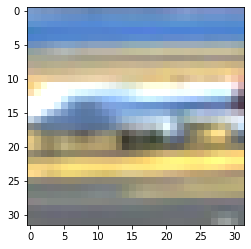

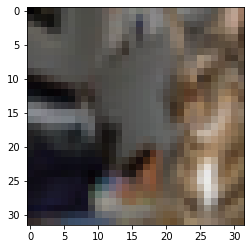

In [106]:
imshow(adjbn_x[0].to('cpu'))
imshow(adjbn_x[1].to('cpu'))

# Batch gray scale

In [107]:
def batch_rgb_to_grayscale(img: Tensor) -> Tensor:
    '''
    Batch x C x H x  W -> Batch x C x H x W
    '''
    if img.shape[1] != 3:
        raise TypeError('Input Image does not contain 3 Channels')
        
    img_tp = img.transpose(0,1)
    img_gray = (0.2989 * img_tp[0] + 0.5870 * img_tp[1] + 0.1140 * img_tp[2])
    return img_gray

In [108]:
x1.size()

torch.Size([336, 3, 32, 32])

In [109]:
x1.transpose(0,1).size() #permute color channel to be the first
x_tp = x1.transpose(0,1)
x_gray = (0.2989 * x_tp[0] + 0.5870 * x_tp[1] + 0.1140 * x_tp[2])

In [110]:
x_gray.unsqueeze(1).size()

torch.Size([336, 1, 32, 32])

In [111]:
x_gray.size()

torch.Size([336, 32, 32])

In [112]:
x_gray = batch_rgb_to_grayscale(x1)

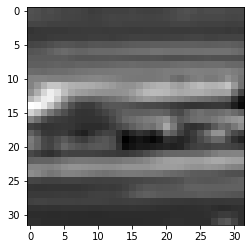

In [113]:
plt.imshow(x_gray[0].to('cpu'), cmap='gray')

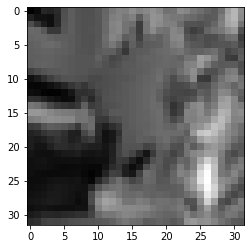

In [114]:
plt.imshow(x_gray[1].to('cpu'), cmap='gray')

# Batch Saturation

In [226]:
# batch saturation brightness
def batch_adjust_saturation(img: Tensor, saturation_bound: list) -> Tensor:
    '''
    Batch x C x H x  W -> Batch x C x H x W
    '''
    
    batch_size = img.size()[0]
    saturation_list = torch.torch.rand(B)*(saturation_bound[1] - saturation_bound[0]) + saturation_bound[0]
    saturation_factor = saturation_list.reshape(B,1,1,1).to(img.device)
#     print(saturation_factor.size())
    
    return _blend(img, batch_rgb_to_grayscale(img).unsqueeze(1), saturation_factor)

In [227]:
adjsat_x = _blend(x1, batch_rgb_to_grayscale(x1).unsqueeze(1), 0.4)

In [228]:
adjsat_x = batch_adjust_saturation(x1, saturation_bound = [0,0.5])

In [118]:
adjsat_x.size()

torch.Size([336, 3, 32, 32])

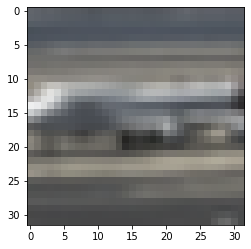

In [119]:
imshow(adjsat_x[0].to('cpu'))

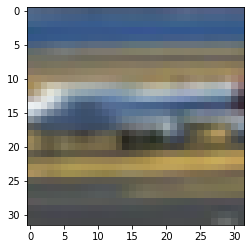

In [120]:
imshow(x1[0].to('cpu'))

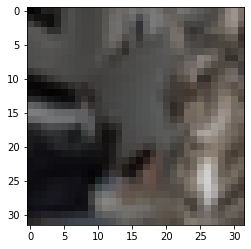

In [121]:
imshow(adjsat_x[1].to('cpu'))

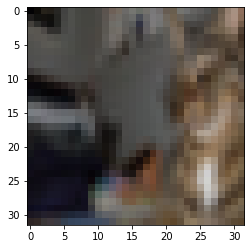

In [122]:
imshow(x1[1].to('cpu'))

In [123]:
test_pic.size()

torch.Size([3, 32, 32])

In [124]:
rgb_to_grayscale(test_pic).size()

torch.Size([32, 32])

In [125]:
test_pic.size()

torch.Size([3, 32, 32])

In [126]:
_blend(test_pic, rgb_to_grayscale(test_pic), 0.3)

tensor([[[0.3819, 0.3929, 0.4062,  ..., 0.4493, 0.3515, 0.3024],
         [0.3619, 0.3682, 0.3752,  ..., 0.4473, 0.3515, 0.3024],
         [0.3243, 0.3213, 0.3154,  ..., 0.4434, 0.3495, 0.3044],
         ...,
         [0.4224, 0.3373, 0.1689,  ..., 0.2261, 0.3625, 0.4296],
         [0.3631, 0.2997, 0.1731,  ..., 0.2541, 0.3983, 0.4713],
         [0.3216, 0.2738, 0.1750,  ..., 0.2691, 0.4133, 0.4895]],

        [[0.3701, 0.4059, 0.4697,  ..., 0.4504, 0.3550, 0.3071],
         [0.3843, 0.4094, 0.4575,  ..., 0.4473, 0.3550, 0.3071],
         [0.4043, 0.4107, 0.4271,  ..., 0.4434, 0.3519, 0.3079],
         ...,
         [0.4353, 0.3538, 0.1913,  ..., 0.2814, 0.4119, 0.4766],
         [0.3808, 0.3197, 0.1978,  ..., 0.3153, 0.4536, 0.5231],
         [0.3404, 0.2950, 0.2009,  ..., 0.3326, 0.4710, 0.5460]],

        [[0.3301, 0.3588, 0.4121,  ..., 0.4516, 0.3574, 0.3095],
         [0.3395, 0.3612, 0.4034,  ..., 0.4485, 0.3574, 0.3095],
         [0.3502, 0.3613, 0.3801,  ..., 0.4446, 0.3543, 0.

# Adjust contrast

In [127]:
test_pic.size()

torch.Size([3, 32, 32])

In [128]:
torch.mean((rgb_to_grayscale(test_pic)))

tensor(0.4868)

In [129]:
torch.mean((rgb_to_grayscale(test_pic).to(torch.float)))

tensor(0.4868)

In [130]:
batch_rgb = batch_rgb_to_grayscale(x1)
batch_rgb.size()

torch.Size([336, 32, 32])

In [131]:
torch.mean(batch_rgb.view(batch_rgb.shape[0],-1), dim = 1).size()

torch.Size([336])

In [132]:
mean = torch.mean(batch_rgb.view(batch_rgb.shape[0],-1), dim = 1)

In [133]:
mean.reshape([mean.size()[0],1,1,1]).size()

torch.Size([336, 1, 1, 1])

In [134]:
_blend(x1, mean.reshape([mean.size()[0],1,1,1]),  2).size()

torch.Size([336, 3, 32, 32])

In [135]:
def batch_adjust_contrast(img: Tensor, contrast_bound: float) -> Tensor:
    '''
    Batch x C x H x  W -> Batch x C x H x W
    '''
    batch_size = img.size()[0]
    contrast_list = torch.torch.rand(B)*(contrast_bound[1] - contrast_bound[0]) + contrast_bound[0]
    contrast_list = contrast_list.reshape(B,1,1,1).to(img.device)
    
    #mean for each pic (over HxW points)
    img_gray = batch_rgb_to_grayscale(img)
    mean = torch.mean(img_gray.view(img_gray.shape[0],-1), dim = 1)
    
    
    return _blend(img, mean.reshape([mean.size()[0],1,1,1]),  contrast_list)
    

In [136]:
adjcon_x = batch_adjust_contrast(x1, contrast_bound = [1.3,1.7])

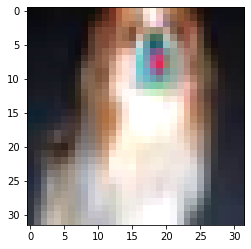

In [137]:
imshow(adjcon_x[2].to('cpu'))

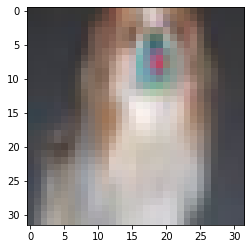

In [138]:
imshow(x1[2].to('cpu'))

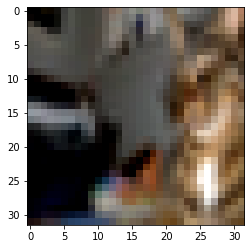

In [139]:
imshow(adjcon_x[1].to('cpu'))

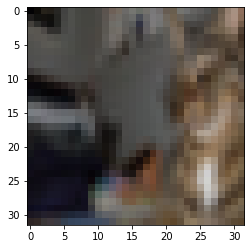

In [140]:
imshow(x1[1].to('cpu'))

# Batch adjust Hue

adjusting hue is quite complicated so I will just apply it n times

In [141]:
def batch_adjust_hue(img: Tensor, hue_bound: float) -> Tensor:
    '''
    Batch x C x H x  W -> Batch x C x H x W
    '''
    batch_size = img.size()[0]
    hue_list = torch.torch.rand(B)*(hue_bound[1] - hue_bound[0]) + hue_bound[0]
    hue_list = hue_list.to(x1.device)
    
    #unbind
    img_u = torch.unbind(img, dim = 0)
    
    
    return torch.stack([adjust_hue(img_i, hue_list[i]) for i, img_i in enumerate(img_u)], dim = 0)

In [142]:
xu = torch.unbind(x1, dim = 0)
img = x1
hue_bound = [-0.5,0.5]
batch_size = img.size()[0]
hue_list = torch.torch.rand(B)*(hue_bound[1] - hue_bound[0]) + hue_bound[0]
hue_list = hue_list.to(x1.device)
# hue_list = hue_list.reshape(B,1,1,1).to(img.device)

In [143]:
x1.size()

torch.Size([336, 3, 32, 32])

In [144]:
hue_list[0]

tensor(-0.1896, device='cuda:0')

In [145]:
adjhue_x = torch.stack([adjust_hue(x_i, hue_list[i]) for i, x_i in enumerate(xu)], dim = 0)

In [146]:
adjhue_x.size()

torch.Size([336, 3, 32, 32])

In [147]:
adjhue_x = batch_adjust_hue(x1, hue_bound = [-0.5,0.5])

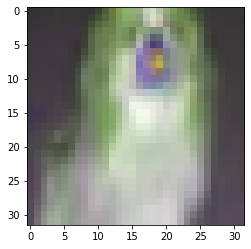

In [148]:
imshow(adjhue_x[2].to('cpu'))

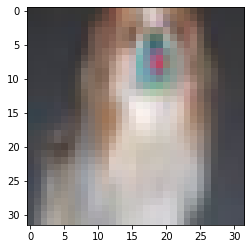

In [149]:
imshow(x1[2].to('cpu'))

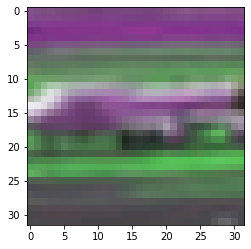

In [150]:
imshow(adjhue_x[0].to('cpu'))

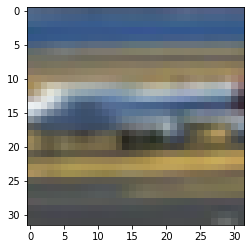

In [151]:
imshow(x1[0].to('cpu'))

# Combine into batch color distortion

In [19]:
class DifferentiableColourDistortionByTorch2(nn.Module):
    
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        super().__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)


    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - float(value), center + float(value)]
            if clip_first_on_zero:
                value[0] = max(value[0], 0.0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value
    
    #### batch color augmentation forward #####
    
    def forward(self, x):
        '''
        Args:
            x: Input tensor batchsize x 32 x 32
        
        Returns:
            x_aug : color jittered image
            
        apply color jitter with prob 0.8
        apply random grayscale with prob 0.2
        
        '''
        batch_size = x.size()[0]
        
        p_jitter = torch.ones(batch_size) * 0.8
        jitter = torch.bernoulli(p_jitter)
        jitter = jitter.reshape(batch_size,1,1,1)

        p_gray = torch.ones(batch_size)* 0.2
        gray = torch.bernoulli(p_gray)
        gray = gray.reshape(batch_size,1,1,1)

        jitter = jitter.to(x.device)
        gray = gray.to(x.device)
        
        #random color jitter
        x_jitter = self.batch_colourjitter(x)
        x = x_jitter * jitter + x *(1-jitter)
        
        #random gray scale
        x_gray = self.batch_rgb_to_grayscale(x).unsqueeze(1)
#         print(x_gray.size())
#         print(gray.size())
        x = x_gray * gray + x* (1-gray)
       
        return x
    
    
    def batch_colourjitter(self, img: Tensor) -> Tensor:
        
        fn_idx = torch.randperm(4)
        for fn_id in fn_idx:
            if fn_id == 0 and self.brightness is not None:
                brightness_bound = self.brightness
                img = self.batch_adjust_brightness(img, brightness_bound)

            if fn_id == 1 and self.contrast is not None:
                contrast_bound = self.contrast
                img = self.batch_adjust_contrast(img, contrast_bound)

            if fn_id == 2 and self.saturation is not None:
                saturation_bound = self.saturation
                img = self.batch_adjust_saturation(img, saturation_bound)

            if fn_id == 3 and self.hue is not None:
                hue_bound = self.hue
                img = self.batch_adjust_hue(img, hue_bound)

        return img
        

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string
                
    ##### function from pytorch source code #####
    def _is_tensor_a_torch_image(self, x: Tensor) -> bool:
        return x.ndim >= 2
    
    def _blend(self, img1: Tensor, img2: Tensor, ratio: float) -> Tensor:
        bound = 1 if img1.dtype in [torch.half, torch.float32, torch.float64] else 255
        return (ratio * img1 + (1 - ratio) * img2).clamp(0, bound).to(img1.dtype)
    
    # batch adjust brightness
    def batch_adjust_brightness(self,img: Tensor, brightness_bound: list) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        B = img.size()[0]
        brightness_list = torch.torch.rand(B)*(brightness_bound[1] - brightness_bound[0]) + brightness_bound[0]
        brightness_factor = brightness_list.reshape(B,1,1,1).to(img.device)
        return self._blend(img, torch.zeros_like(img), brightness_factor)
    
    def batch_rgb_to_grayscale(self,img: Tensor) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        if img.shape[1] != 3:
            raise TypeError('Input Image does not contain 3 Channels')

        img_tp = img.transpose(0,1)
        img_gray = (0.2989 * img_tp[0] + 0.5870 * img_tp[1] + 0.1140 * img_tp[2])
        return img_gray
    
    def batch_adjust_saturation(self,img: Tensor, saturation_bound: list) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''

        B = img.size()[0]
        saturation_list = torch.torch.rand(B)*(saturation_bound[1] - saturation_bound[0]) + saturation_bound[0]
        saturation_factor = saturation_list.reshape(B,1,1,1).to(img.device)
    #     print(saturation_factor.size())

        return self._blend(img, self.batch_rgb_to_grayscale(img).unsqueeze(1), saturation_factor)
    
    def batch_adjust_contrast(self,img: Tensor, contrast_bound: float) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        B = img.size()[0]
        contrast_list = torch.torch.rand(B)*(contrast_bound[1] - contrast_bound[0]) + contrast_bound[0]
        contrast_list = contrast_list.reshape(B,1,1,1).to(img.device)

        #mean for each pic (over HxW points)
        img_gray = self.batch_rgb_to_grayscale(img)
        mean = torch.mean(img_gray.view(img_gray.shape[0],-1), dim = 1)


        return self._blend(img, mean.reshape([mean.size()[0],1,1,1]),  contrast_list)
    
    def batch_adjust_hue(self, img: Tensor, hue_bound: float) -> Tensor:
        '''
        Batch x C x H x  W -> Batch x C x H x W
        '''
        B = img.size()[0]
        hue_list = torch.torch.rand(B)*(hue_bound[1] - hue_bound[0]) + hue_bound[0]
        hue_list = hue_list.to(img.device)

        #unbind
        img_u = torch.unbind(img, dim = 0)


        return torch.stack([self.adjust_hue(img_i, hue_list[i]) for i, img_i in enumerate(img_u)], dim = 0)
    
    
    def _rgb2hsv(self, img):
        r, g, b = img.unbind(0)

        maxc = torch.max(img, dim=0).values
        minc = torch.min(img, dim=0).values

        # The algorithm erases S and H channel where `maxc = minc`. This avoids NaN
        # from happening in the results, because
        #   + S channel has division by `maxc`, which is zero only if `maxc = minc`
        #   + H channel has division by `(maxc - minc)`.
        #
        # Instead of overwriting NaN afterwards, we just prevent it from occuring so
        # we don't need to deal with it in case we save the NaN in a buffer in
        # backprop, if it is ever supported, but it doesn't hurt to do so.
        eqc = maxc == minc

        cr = maxc - minc
        # Since `eqc => cr = 0`, replacing denominator with 1 when `eqc` is fine.
        s = cr / torch.where(eqc, maxc.new_ones(()), maxc)
        # Note that `eqc => maxc = minc = r = g = b`. So the following calculation
        # of `h` would reduce to `bc - gc + 2 + rc - bc + 4 + rc - bc = 6` so it
        # would not matter what values `rc`, `gc`, and `bc` have here, and thus
        # replacing denominator with 1 when `eqc` is fine.
        cr_divisor = torch.where(eqc, maxc.new_ones(()), cr)
        rc = (maxc - r) / cr_divisor
        gc = (maxc - g) / cr_divisor
        bc = (maxc - b) / cr_divisor

    #     hr = (maxc == r) * (bc - gc)
    #     hg = ((maxc == g) & (maxc != r)) * (2.0 + rc - bc)
    #     hb = ((maxc != g) & (maxc != r)) * (4.0 + gc - rc)   
        hr = (maxc == r).float() * (bc - gc)
        hg = ((maxc == g) & (maxc != r)).float() * (2.0 + rc - bc)
        hb = ((maxc != g) & (maxc != r)).float() * (4.0 + gc - rc)
        h = (hr + hg + hb)
        h = torch.fmod((h / 6.0 + 1.0), 1.0)
        return torch.stack((h, s, maxc))
    
    def _hsv2rgb(self, img):
        h, s, v = img.unbind(0)
        i = torch.floor(h * 6.0)
        f = (h * 6.0) - i
        i = i.to(dtype=torch.int32)

        p = torch.clamp((v * (1.0 - s)), 0.0, 1.0)
        q = torch.clamp((v * (1.0 - s * f)), 0.0, 1.0)
        t = torch.clamp((v * (1.0 - s * (1.0 - f))), 0.0, 1.0)
        i = i % 6

    #     mask = i == torch.arange(6)[:, None, None]
        mask = (i == torch.arange(6)[:, None, None].to(img.device).int())
        a1 = torch.stack((v, q, p, p, t, v))
        a2 = torch.stack((t, v, v, q, p, p))
        a3 = torch.stack((p, p, t, v, v, q))
        a4 = torch.stack((a1, a2, a3))

        return torch.einsum("ijk, xijk -> xjk", mask.to(dtype=img.dtype), a4)
    
    def adjust_hue(self, img, hue_factor):

        if not (-0.5 <= hue_factor <= 0.5):
            raise ValueError('hue_factor ({}) is not in [-0.5, 0.5].'.format(hue_factor))

        if not self._is_tensor_a_torch_image(img):
            raise TypeError('tensor is not a torch image.')

        orig_dtype = img.dtype
        if img.dtype == torch.uint8:
            img = img.to(dtype=torch.float32) / 255.0

        img = self._rgb2hsv(img)
        h, s, v = img.unbind(0)
        h += hue_factor
        h = h % 1.0
        img = torch.stack((h, s, v))
        img_hue_adj = self._hsv2rgb(img)

        if orig_dtype == torch.uint8:
            img_hue_adj = (img_hue_adj * 255.0).to(dtype=orig_dtype)

        return img_hue_adj
    
   

In [20]:
aug = DifferentiableColourDistortionByTorch2(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)

In [21]:
aug(x1).size()

torch.Size([336, 3, 32, 32])

In [14]:
aug_x1 = aug(x1)


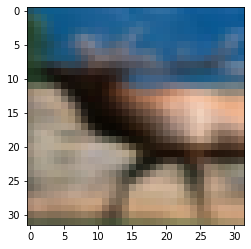

In [30]:
imshow(x1[7].to('cpu'))

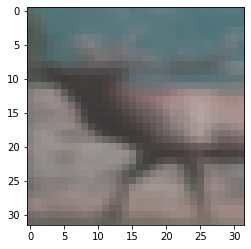

In [31]:
imshow(aug_x1[7].to('cpu'))

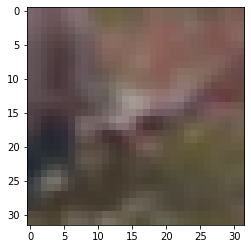

In [16]:
imshow(aug_x1[1].to('cpu'))

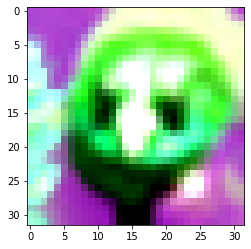

In [17]:
imshow(aug_x1[2].to('cpu'))

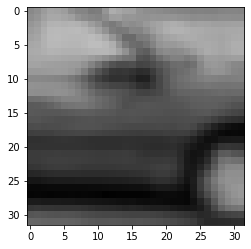

In [18]:
imshow(aug_x1[3].to('cpu'))

# normalise !!

In [152]:
#### Mean _std for normalising after augmentation ####
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

normalise = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])

In [153]:
x1_aug = aug(x1)

In [154]:
x1_aug.size()

torch.Size([336, 3, 32, 32])

In [155]:
mean = CACHED_MEAN_STD[dataset][0]
std = CACHED_MEAN_STD[dataset][1]

In [156]:
torch.stack([torch.tensor(mean[i]).repeat(32,32) for i in range(3)], dim = 0)

tensor([[[0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914],
         [0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914],
         [0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914],
         ...,
         [0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914],
         [0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914],
         [0.4914, 0.4914, 0.4914,  ..., 0.4914, 0.4914, 0.4914]],

        [[0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822],
         [0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822],
         [0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822],
         ...,
         [0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822],
         [0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822],
         [0.4822, 0.4822, 0.4822,  ..., 0.4822, 0.4822, 0.4822]],

        [[0.4465, 0.4465, 0.4465,  ..., 0.4465, 0.4465, 0.4465],
         [0.4465, 0.4465, 0.4465,  ..., 0.4465, 0.4465, 0.4465],
         [0.4465, 0.4465, 0.4465,  ..., 0.4465, 0.4465, 0.

In [157]:
torch.stack([torch.tensor(mean[i]).repeat(32,32) for i in range(3)], dim = 0).repeat(336,1,1,1).size()

torch.Size([336, 3, 32, 32])

In [158]:
mean_batch = torch.stack([torch.tensor(mean[i]).repeat(32,32) for i in range(3)], dim = 0).repeat(336,1,1,1)
std_batch = torch.stack([torch.tensor(std[i]).repeat(32,32) for i in range(3)], dim = 0).repeat(336,1,1,1)

In [159]:
x1_aug.size()

torch.Size([336, 3, 32, 32])

In [160]:
x1_aug.size()

torch.Size([336, 3, 32, 32])

In [161]:
B = x1_aug.size()[0]
C = x1_aug.size()[1]
H = x1_aug.size()[2]
W = x1_aug.size()[3]

In [162]:
H

32

In [163]:
mean_batch = torch.stack([torch.tensor(mean[i]).repeat(H,W) for i in range(C)], dim = 0).repeat(B,1,1,1)
std_batch = torch.stack([torch.tensor(std[i]).repeat(H,W) for i in range(C)], dim = 0).repeat(B,1,1,1)
mean_batch = mean_batch.to(x1_aug.device)
std_batch = std_batch.to(x1_aug.device)

In [164]:
(mean/std).size()

TypeError: unsupported operand type(s) for /: 'tuple' and 'tuple'

In [ ]:
normx1 = (x1_aug - mean_batch)/std_batch

In [ ]:
normx1.size()

In [ ]:
def ManualNormalise(x, dataset):
    CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }
    
    mean = CACHED_MEAN_STD[dataset][0]
    std = CACHED_MEAN_STD[dataset][1]
    
    #batch x channel x height x wide
    B = x.size()[0]
    C = x.size()[1]
    H = x.size()[2]
    W = x.size()[3]
    
    #create a matrix
    mean_batch = torch.stack([torch.tensor(mean[i]).repeat(H,W) for i in range(C)], dim = 0).repeat(B,1,1,1)
    std_batch = torch.stack([torch.tensor(std[i]).repeat(H,W) for i in range(C)], dim = 0).repeat(B,1,1,1)
    mean_batch = mean_batch.to(x.device)
    std_batch = std_batch.to(x.device)
    
    norm_x = (x - mean_batch)/std_batch
    
    return norm_x
    
    

end

In [209]:
B = x1.size()[0]
p_jitter = torch.ones(B) * 0.8
jitter = torch.bernoulli(p_jitter)
jitter = jitter.reshape(B,1,1,1)

p_gray = torch.ones(B)* 0.2
gray = torch.bernoulli(p_gray)
gray = gray.reshape(B,1,1,1)

jitter = jitter.to(x1.device)
gray = gray.to(x1.device)

In [203]:
x1.size()

torch.Size([336, 3, 32, 32])

In [212]:
x1_adjbrightness = batch_adjust_brightness(x1, brightness_bound = [0.1,0.2])

In [214]:
x1_randombn = x1_adjbrightness * jitter + x1 *(1-jitter)

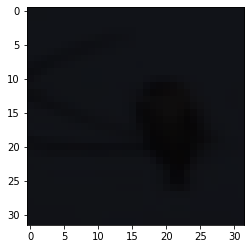

In [217]:
imshow(x1_randombn[12].to('cpu'))

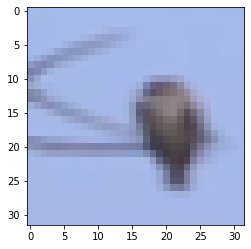

In [218]:
imshow(x1[12].to('cpu'))

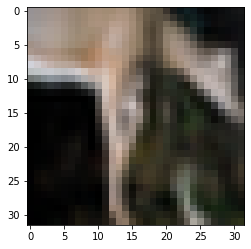

In [216]:
imshow(x1_randombn[13].to('cpu'))

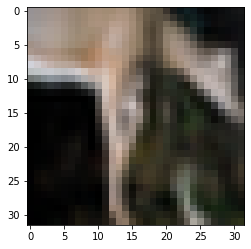

In [219]:
imshow(x1[13].to('cpu'))